# Assignment: Probability, Bayesian Probability, and Gradient Descent
_Group 6_

### Group Members
- David Akintayo: Probability Distributions  
- Cynthia Mutie: Bayesian Probability  
- Sougnabe Payang: Manual Gradient Descent  
- Elvis Kayonga: Linear Regression with SciPy

## Part 0 — Data Setup
Load and explore the dataset to be used across all sections.


In [ ]:
import pandas as pd

# Name the columns so we understand the data
col_names = ["sepal_length", "sepal_width", "petal_length", "petal_width", "species"]

# Download the data from the internet and load it
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",
    header=None, names=col_names
)

# Show the first 5 rows
df.head()


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Part 1 — Probability Distributions (David Akintayo)

Implement and compare key **probability distributions** using the Iris dataset (Sepal Length vs Sepal Width).  
Tasks:
- Compute and visualize probability distributions (e.g., Normal, Uniform, Exponential).  
- Plot histograms and fit curves for each feature.  
- Analyze which distribution best fits each variable.

**Author:** David Oluwadamipe Akintayo


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from mpl_toolkits.mplot3d import Axes3D

iris_data = load_iris()
iris = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
data = iris[["sepal length (cm)", "sepal width (cm)"]].values
iris.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [3]:
mu = np.mean(data, axis=0)
cov = np.cov(data, rowvar=False)

print("Mean (μ):", mu)
print("Covariance matrix:\n", cov)


Mean (μ): [5.84333333 3.05733333]
Covariance matrix:
 [[ 0.68569351 -0.042434  ]
 [-0.042434    0.18997942]]


In [4]:
def bivariate_pdf(x, mu, cov):
    x = np.atleast_2d(x)
    k = 2
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    norm_const = 1.0 / ((2 * np.pi) ** (k / 2) * np.sqrt(det_cov))
    diffs = x - mu
    exponents = -0.5 * np.sum(diffs.dot(inv_cov) * diffs, axis=1)
    return norm_const * np.exp(exponents)

pdf_vals = bivariate_pdf(data, mu, cov)
print("First 5 PDF values:", pdf_vals[:5])


First 5 PDF values: [0.19501944 0.2239222  0.16883387 0.14338704 0.13911437]


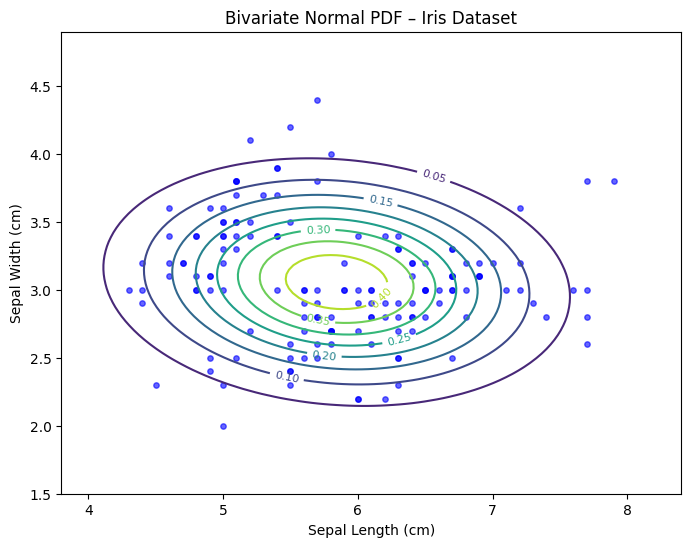

In [5]:
x_min, x_max = data[:,0].min() - 0.5, data[:,0].max() + 0.5
y_min, y_max = data[:,1].min() - 0.5, data[:,1].max() + 0.5
X, Y = np.meshgrid(np.linspace(x_min, x_max, 100),
                   np.linspace(y_min, y_max, 100))
grid = np.column_stack([X.ravel(), Y.ravel()])
Z = bivariate_pdf(grid, mu, cov).reshape(X.shape)

plt.figure(figsize=(8,6))
plt.scatter(data[:,0], data[:,1], c='blue', s=15, alpha=0.6)
contours = plt.contour(X, Y, Z, levels=10, cmap='viridis')
plt.clabel(contours, inline=True, fontsize=8)
plt.title("Bivariate Normal PDF – Iris Dataset")
plt.xlabel("Sepal Length (cm)")
plt.ylabel("Sepal Width (cm)")
plt.show()


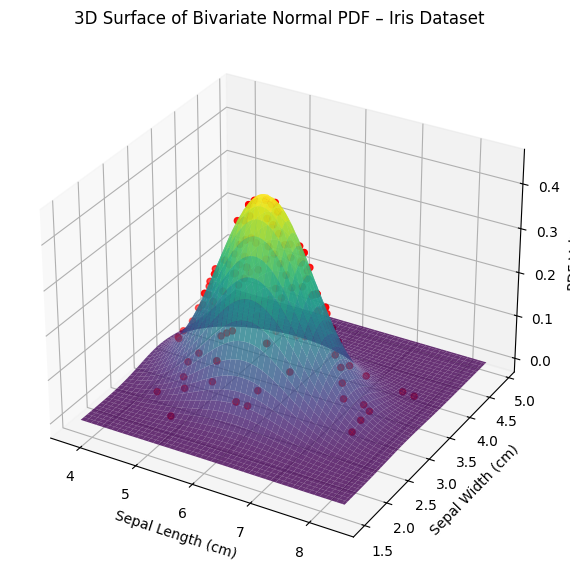

In [6]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
ax.scatter(data[:,0], data[:,1], pdf_vals, c='red', s=20)
ax.set_xlabel("Sepal Length (cm)")
ax.set_ylabel("Sepal Width (cm)")
ax.set_zlabel("PDF Value")
ax.set_title("3D Surface of Bivariate Normal PDF – Iris Dataset")
plt.show()


### Formula for the Bivariate Normal Distribution

The general form of the 2-D normal probability density function is:

\[
f(x,y)=\frac{1}{2\pi\sqrt{|\Sigma|}}
\exp\left(-\frac{1}{2}([x-\mu]^T\Sigma^{-1}[x-\mu])\right)
\]

where  
- \( \mu \) is the mean vector,  
- \( \Sigma \) is the covariance matrix, and  
- \( |Σ| \) and \( Σ^{-1} \) are the determinant and inverse of the covariance matrix, respectively.



### Observations
- The data clusters around the mean \([5.84, 3.06]\).  
- Covariance ≈ −0.04 → weak negative correlation.  
- Contours are nearly circular → low correlation.  
- 3D plot shows a single peak, consistent with a unimodal distribution.


## Part 2 — Bayesian Probability (Cynthia Mutie)
Dataset: IMDb Movie Reviews (50k) — file in repo: `data/IMDB Dataset.csv`

Objective: For chosen keywords compute:
- Prior: P(Positive)
- Likelihood: P(keyword | Positive)
- Marginal: P(keyword)
- Posterior: P(Positive | keyword)

We will compute P(Positive | keyword) using plain Python + pandas only.


In [ ]:
# --- Step 1: Load IMDb Dataset and clean text ---
import pandas as pd

# Load dataset
DATA_PATH = "../data/IMDB Dataset.csv"  # adjust path if needed
df = pd.read_csv(DATA_PATH)
print("✅ Dataset loaded successfully!")

# Clean the reviews (lowercase)
df['review_clean'] = df['review'].str.lower()

# Show first 5 rows to confirm
df.head()


✅ Dataset loaded successfully!


,review,sentiment,review_clean
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. <br /><br />the...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is..."


In [ ]:
# --- Define keywords and compute prior P(Positive) ---
import numpy as np

# Chosen keywords
positive_keywords = ['great', 'excellent', 'amazing', 'wonderful']
negative_keywords = ['bad', 'boring', 'awful', 'worst']

# Decide to calculate P(Positive | keyword)
target = 'positive'

# Compute prior: P(Positive)
p_positive = (df['sentiment'] == 'positive').mean()
print(f"Prior P(Positive) = {p_positive:.3f}")

# Compute keyword statistics
results = []

for word in positive_keywords + negative_keywords:
    has_word = df['review_clean'].str.contains(word, na=False)
    p_word = has_word.mean()  # marginal P(keyword)
    p_word_given_pos = df.loc[df['sentiment'] == 'positive', 'review_clean'].str.contains(word, na=False).mean()

    # Avoid division by zero
    posterior = (p_word_given_pos * p_positive) / p_word if p_word > 0 else 0

    results.append({
        'Keyword': word,
        'P(Positive)': round(p_positive, 3),
        'P(keyword|Positive)': round(p_word_given_pos, 3),
        'P(keyword)': round(p_word, 3),
        'P(Positive|keyword)': round(posterior, 3)
    })

# Display table
results_df = pd.DataFrame(results)
results_df


Prior P(Positive) = 0.500


,Keyword,P(Positive),P(keyword|Positive),P(keyword),P(Positive|keyword)
0,great,0.5,0.371,0.276,0.672
1,excellent,0.5,0.117,0.072,0.810
2,amazing,0.5,0.074,0.050,0.746
3,wonderful,0.5,0.107,0.065,0.820
4,bad,0.5,0.130,0.254,0.256
5,boring,0.5,0.025,0.062,0.198
6,awful,0.5,0.014,0.062,0.109
7,worst,0.5,0.016,0.089,0.093


In [ ]:
# --- Bayes function and print posterior nicely ---

def bayes_posterior(p_positive, p_word_given_pos, p_word):
    """Compute P(Positive|keyword) using Bayes' theorem"""
    if p_word == 0:  # avoid division by zero
        return 0
    return (p_word_given_pos * p_positive) / p_word

print("🔍 Posterior probabilities for each keyword:\n")

for word in positive_keywords:
    has_word = df['review_clean'].str.contains(word, na=False)
    p_word = has_word.mean()
    p_word_given_pos = df.loc[df['sentiment'] == 'positive', 'review_clean'].str.contains(word, na=False).mean()
    posterior = bayes_posterior(p_positive, p_word_given_pos, p_word)

    print(f"{word:12s} -> P(Positive|{word}) = {posterior:.3f}")

print("\n✅ All probabilities computed successfully!")


🔍 Posterior probabilities for each keyword:

great        -> P(Positive|great) = 0.672
excellent    -> P(Positive|excellent) = 0.810
amazing      -> P(Positive|amazing) = 0.746
wonderful    -> P(Positive|wonderful) = 0.820

✅ All probabilities computed successfully!


## Part 3 — Manual Gradient Descent (Sougnabe Payang)

Manually calculate the **gradient descent steps** for a simple cost function:  
\[
J(m, b) = \frac{1}{n}\sum_{i=1}^n (y_i - (mx_i + b))^2
\]
Tasks:
- Derive partial derivatives of \(J\) with respect to \(m\) and \(b\).  
- Implement manual gradient descent using loops.


## Part 4 — Gradient Descent with SciPy (Elvis Kayonga)

Use the **SciPy library** to perform linear regression using optimization tools.  
Compare manual vs. automatic gradient descent results.
